# NLI Results Analysis

Maybe: 
- Clustering: Apply hierarchical clustering on the performance matrix to detect groupings of languages with similar transfer characteristics.

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import json
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
import lang2vec.lang2vec  as l2v
import pandas as pd
from scipy.stats import spearmanr, pearsonr
import numpy as np
import math

In [4]:
from analysis import *

### Load data

In [5]:
path = "../nli/results.json"

# Results structure: {lang_eval: {lang_train: {data_fraction: {metric: score}}}}
with open(path, 'r') as file:
    results_per_eval = json.load(file)

print(results_per_eval.keys())

dict_keys(['ar', 'bg', 'de', 'el', 'en', 'es', 'fr', 'hi', 'ru', 'sw', 'th', 'tr', 'ur', 'vi', 'zh'])


In [6]:
# Restructure results to {lang_train: {lang_eval: {data_fraction: {metric: score}}}} for easier plotting
results_per_train = invert_structure(results_per_eval)
print(results_per_train.keys())

dict_keys(['ar', 'bg', 'de', 'el', 'en', 'es', 'fr', 'hi', 'ru', 'sw', 'th', 'tr', 'ur', 'vi', 'zh'])


### Plot all results

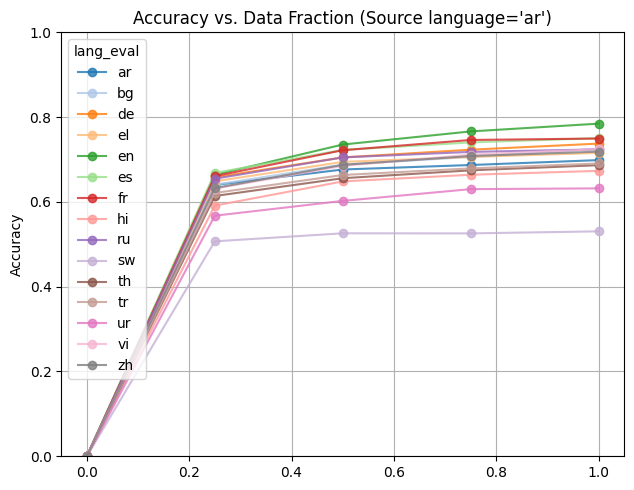

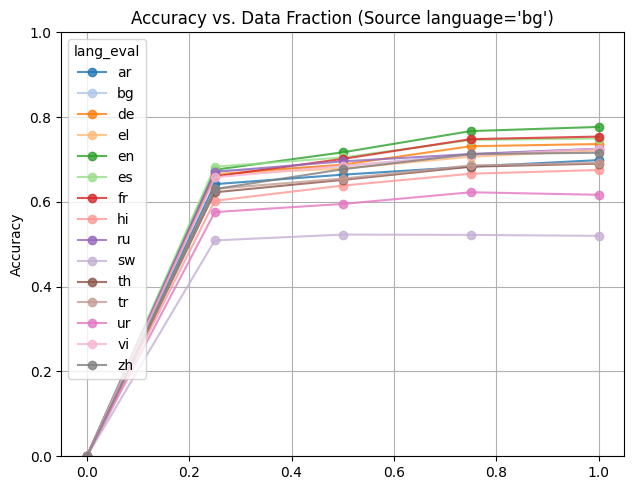

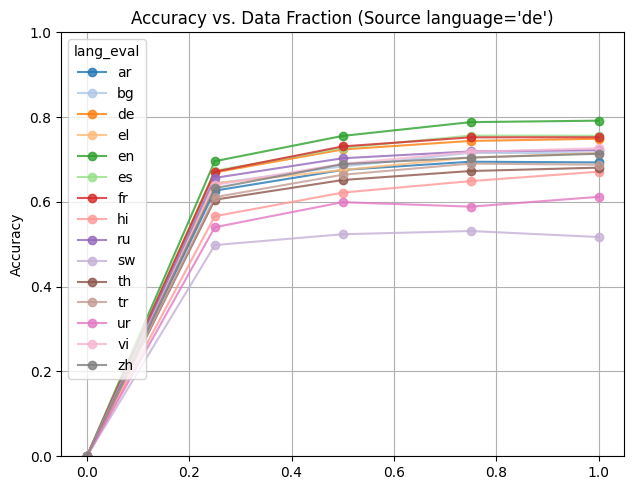

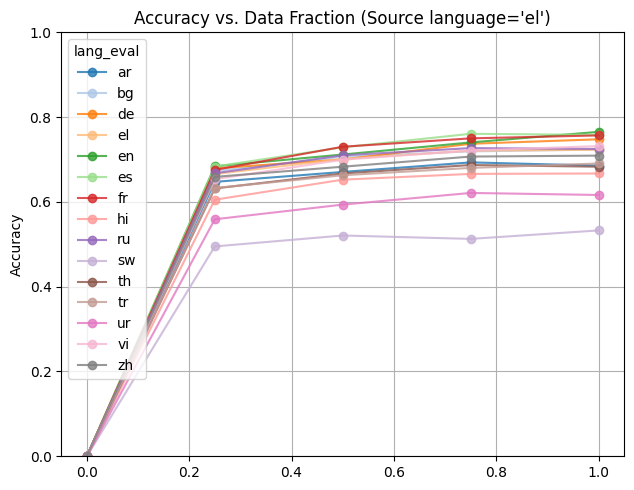

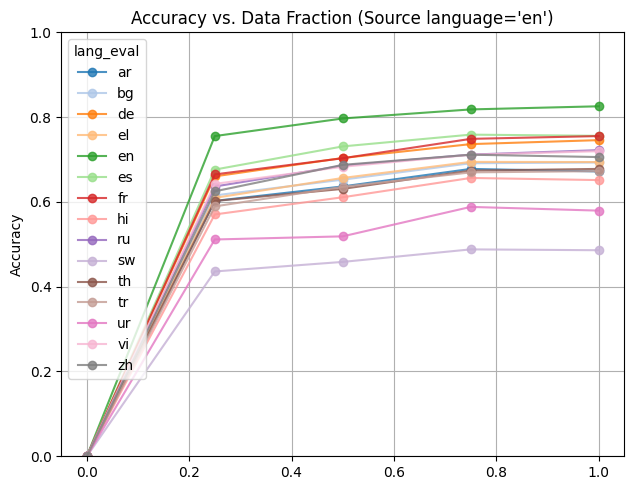

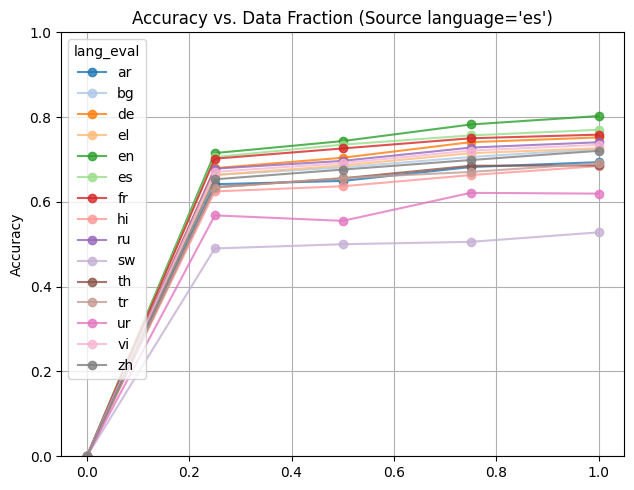

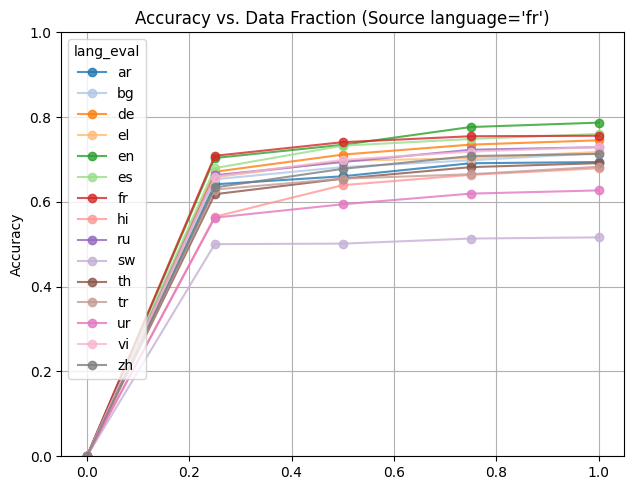

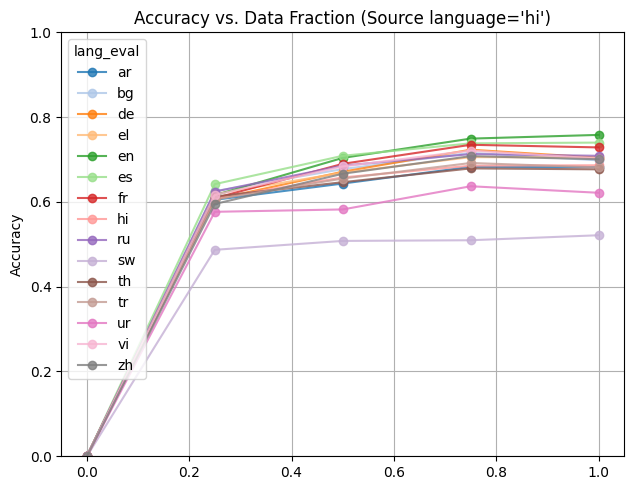

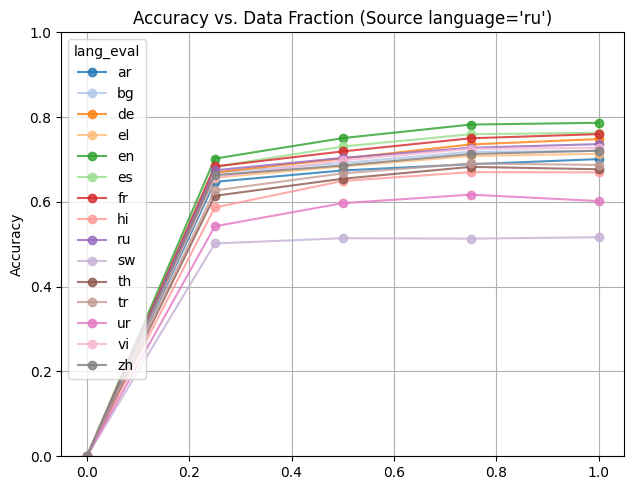

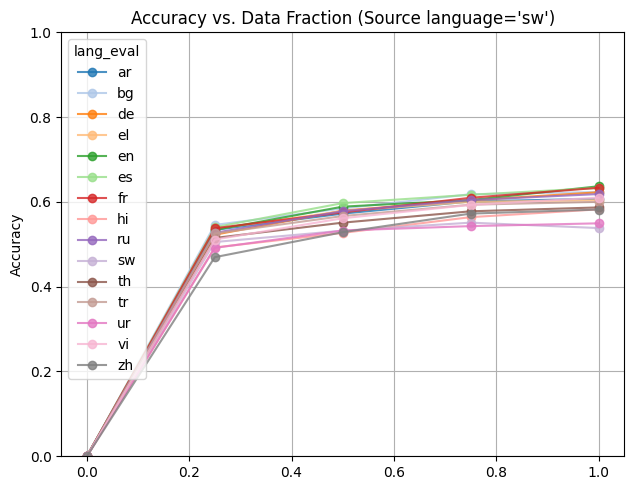

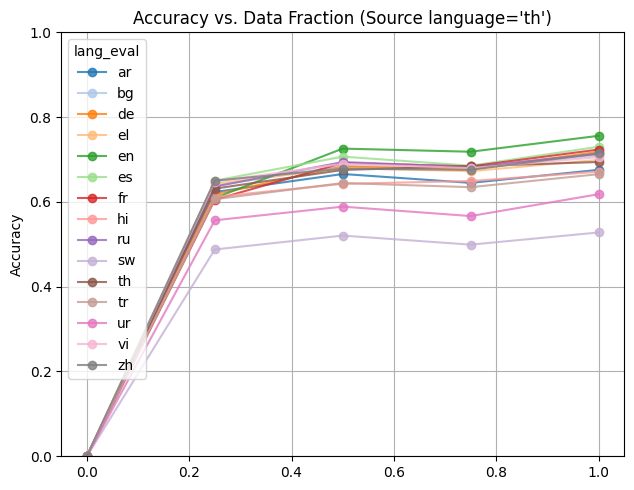

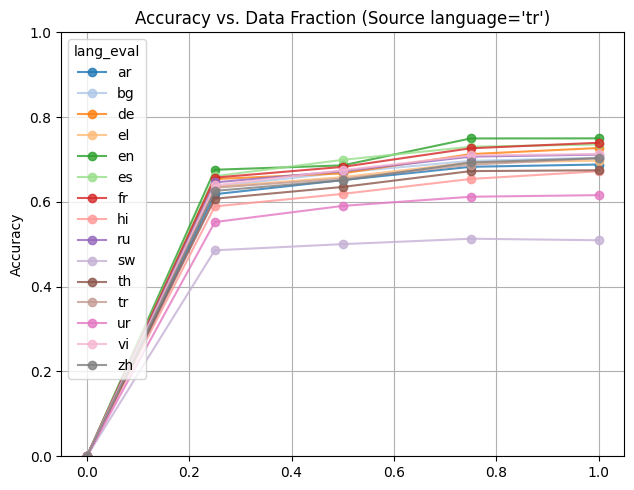

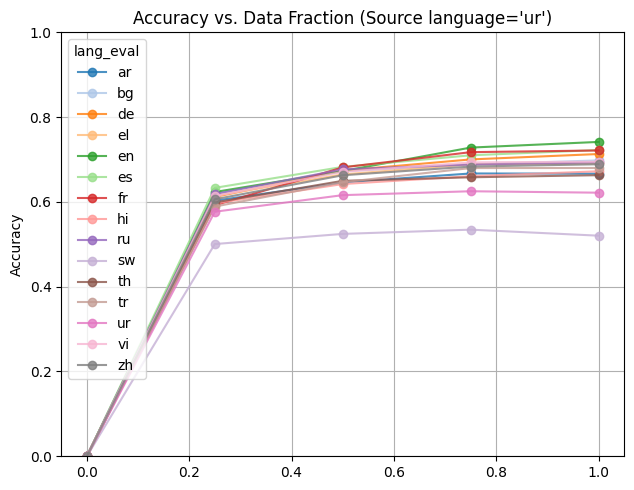

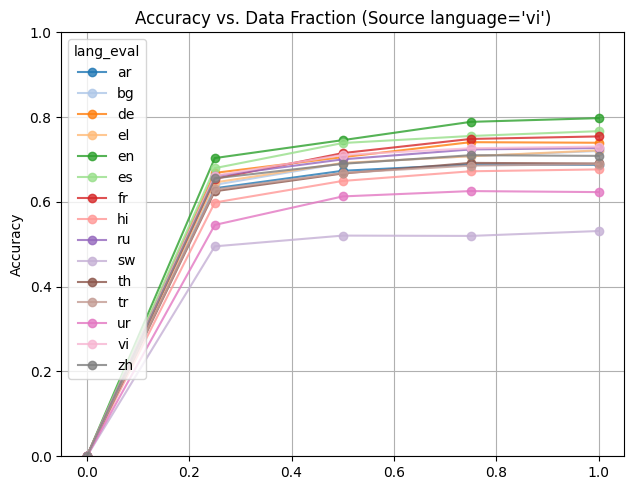

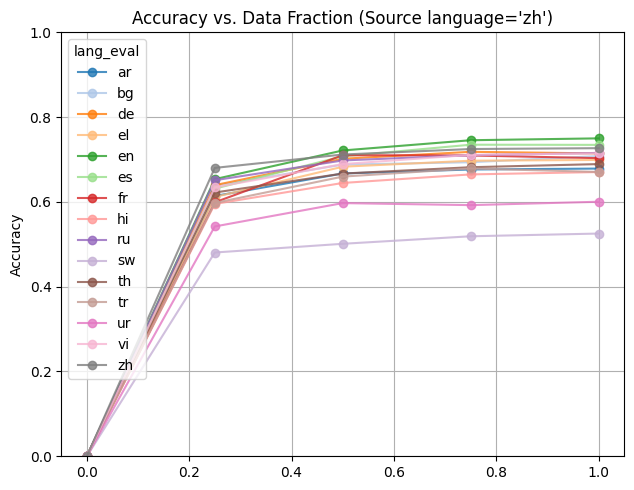

In [7]:
for lang in results_per_train.keys():
    plot_results(results_per_train, lang_train=lang, metrics='accuracy')


## RQ1.  Language Similarity: Does the language similarity affect the performance of zero-shot transfer learning?

- Determine whether closer languages result in better transfer performance in the zero-shot setting.  
    - Compute correlation between language similarity and performance (per language and overall) at X% of data.

In [8]:
languages = list(results_per_eval.keys())

langs_three_digits = get_langs_three_digits(languages)

len(languages), len(langs_three_digits)

(15, 15)

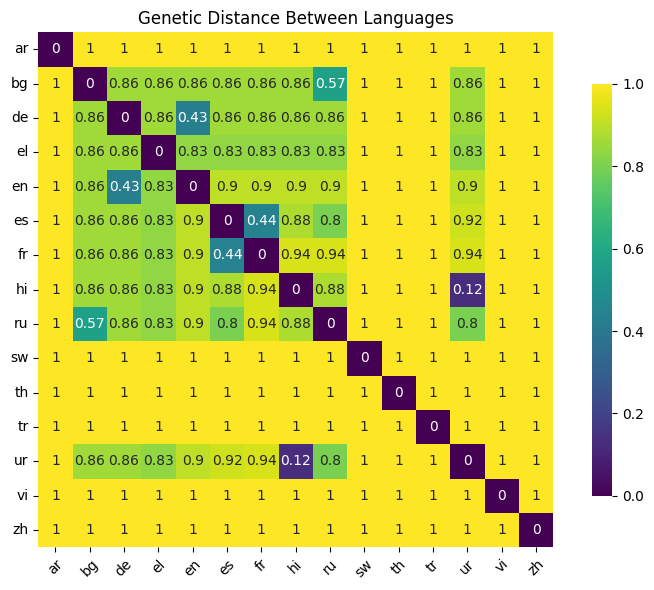

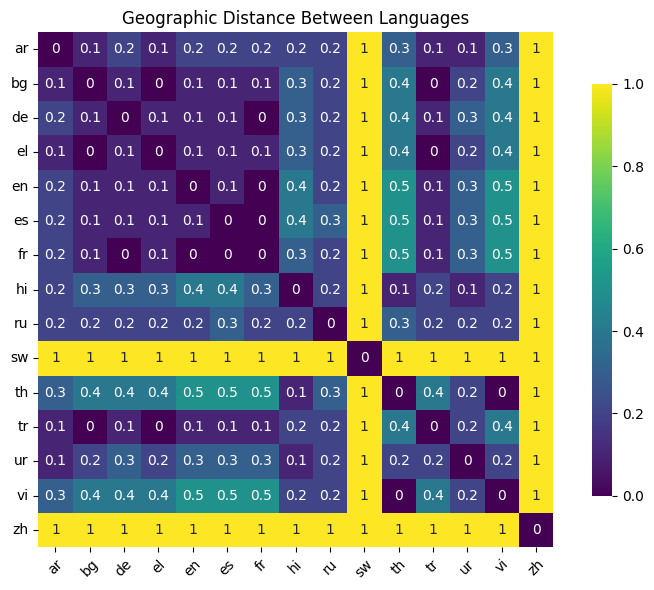

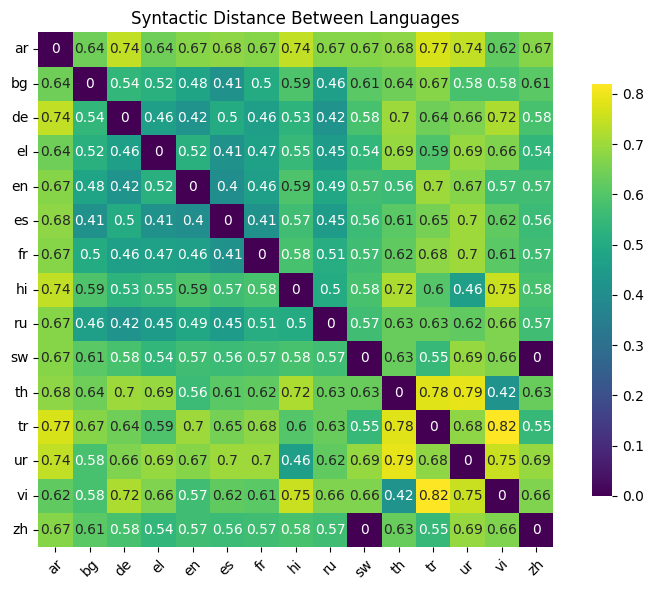

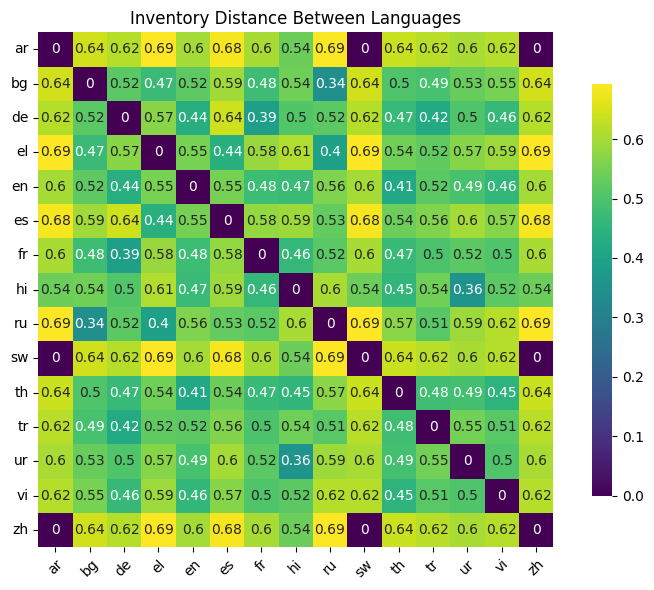

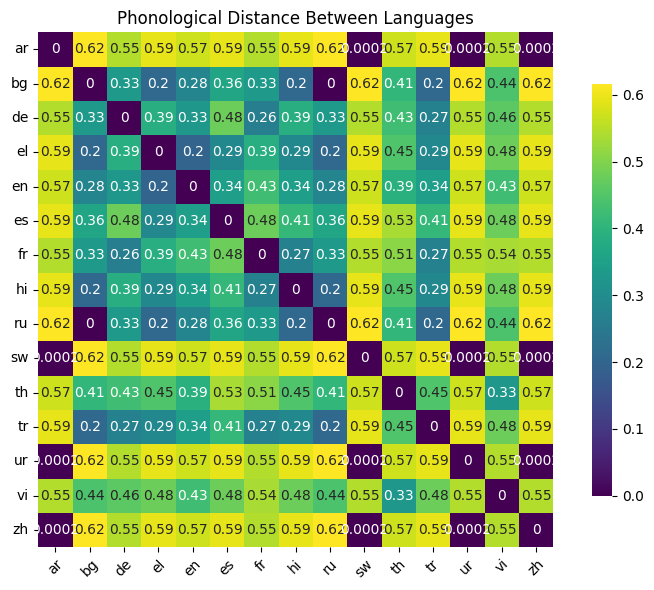

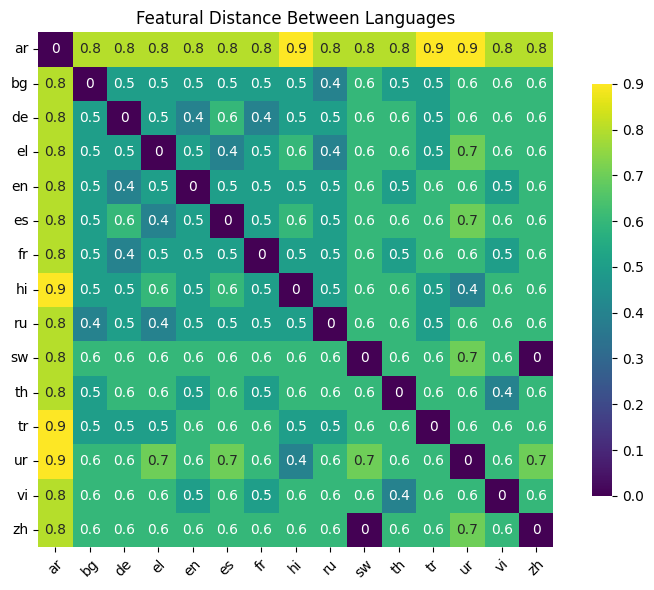

In [9]:
distance_matrices = defaultdict(list)
distance_dfs = defaultdict(pd.DataFrame)
for distance in l2v.DISTANCES:
    distance_matrices[distance] = l2v.distance(distance, langs_three_digits)

    distance_matrix = distance_matrices[distance]

    distance_dfs[distance] = pd.DataFrame(distance_matrix, index=languages, columns=languages)
    distance_df = distance_dfs[distance]

    plt.figure(figsize=(8, 6))
    sns.heatmap(distance_df, annot=True, cmap='viridis', square=True, cbar_kws={"shrink": 0.8})
    plt.title(f"{distance.capitalize()} Distance Between Languages")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
distance_df = None

DISTANCE = 'geographic'

### Correlation (distance vs. accuracy) and accuracy heatmap

In [10]:
data_fractions = list(results_per_eval[next(iter(results_per_eval))][next(iter(results_per_eval[next(iter(results_per_eval))]))].keys())

for frac in data_fractions:
    compute_correlation(results_per_eval, distance_dfs, DISTANCE, metric = 'accuracy', data_fraction = frac, visualize_heatmap=False)

Spearman correlation for geographic distance (data fraction = 0.0): nan (p = nan)
Spearman correlation for geographic distance (data fraction = 0.25): -0.490 (p = 5.2e-15)
Spearman correlation for geographic distance (data fraction = 0.5): -0.350 (p = 6.65e-08)
Spearman correlation for geographic distance (data fraction = 0.75): -0.393 (p = 1.03e-09)
Spearman correlation for geographic distance (data fraction = 1.0): -0.384 (p = 2.68e-09)


/home/nico/Documents/repositories/projects/eth/CSNLP/CS4NLP-Cross-Lingual-Task-Adaptation/notebooks/analysis.py:148: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, pval = spearmanr(distances, accuracies)


Spearman correlation for geographic distance (data fraction = 1.0): -0.384 (p = 2.68e-09)


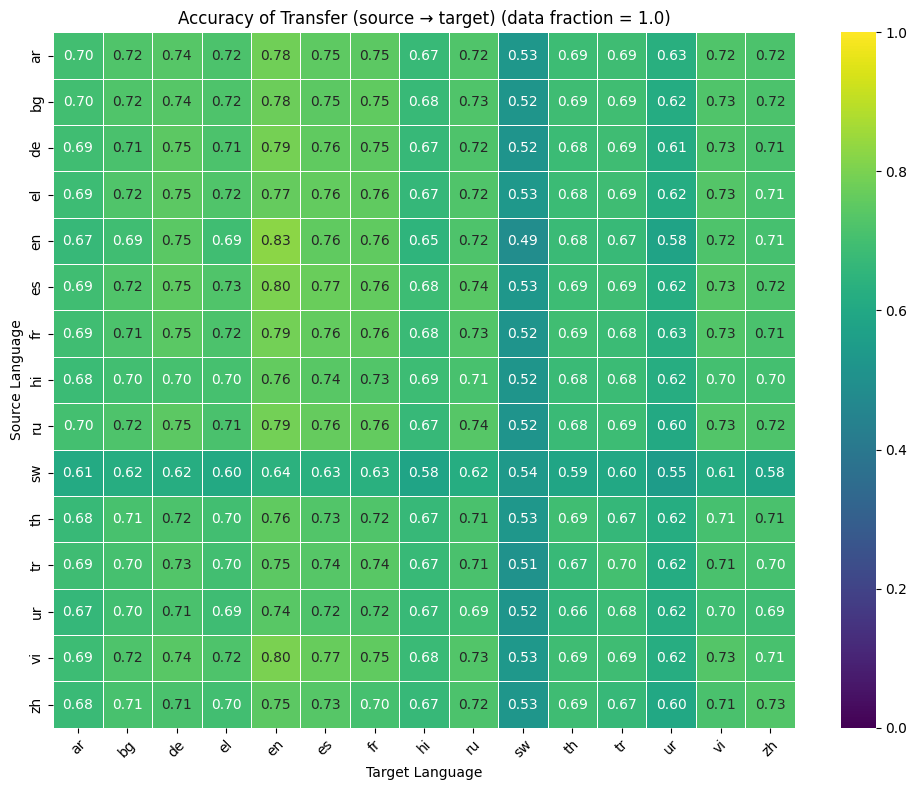

In [11]:
compute_correlation(results_per_eval, distance_dfs, DISTANCE, metric = 'accuracy', data_fraction = 1.0, visualize_heatmap=True)

Spearman correlation for geographic distance (data fraction = 0.25): -0.490 (p = 5.2e-15)


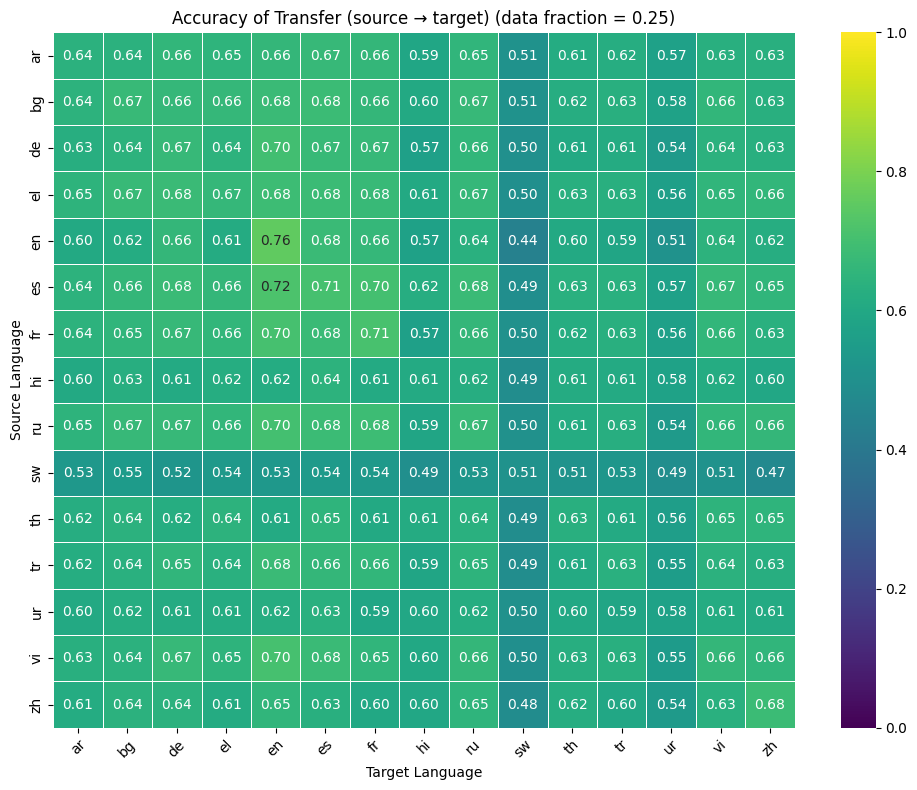

In [12]:
compute_correlation(results_per_eval, distance_dfs, DISTANCE, metric = 'accuracy', data_fraction = 0.25, visualize_heatmap=True)

### Distance vs. accuracy per source language

/home/nico/Documents/repositories/projects/eth/CSNLP/CS4NLP-Cross-Lingual-Task-Adaptation/notebooks/analysis.py:199: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = spearmanr(distances, accuracies)


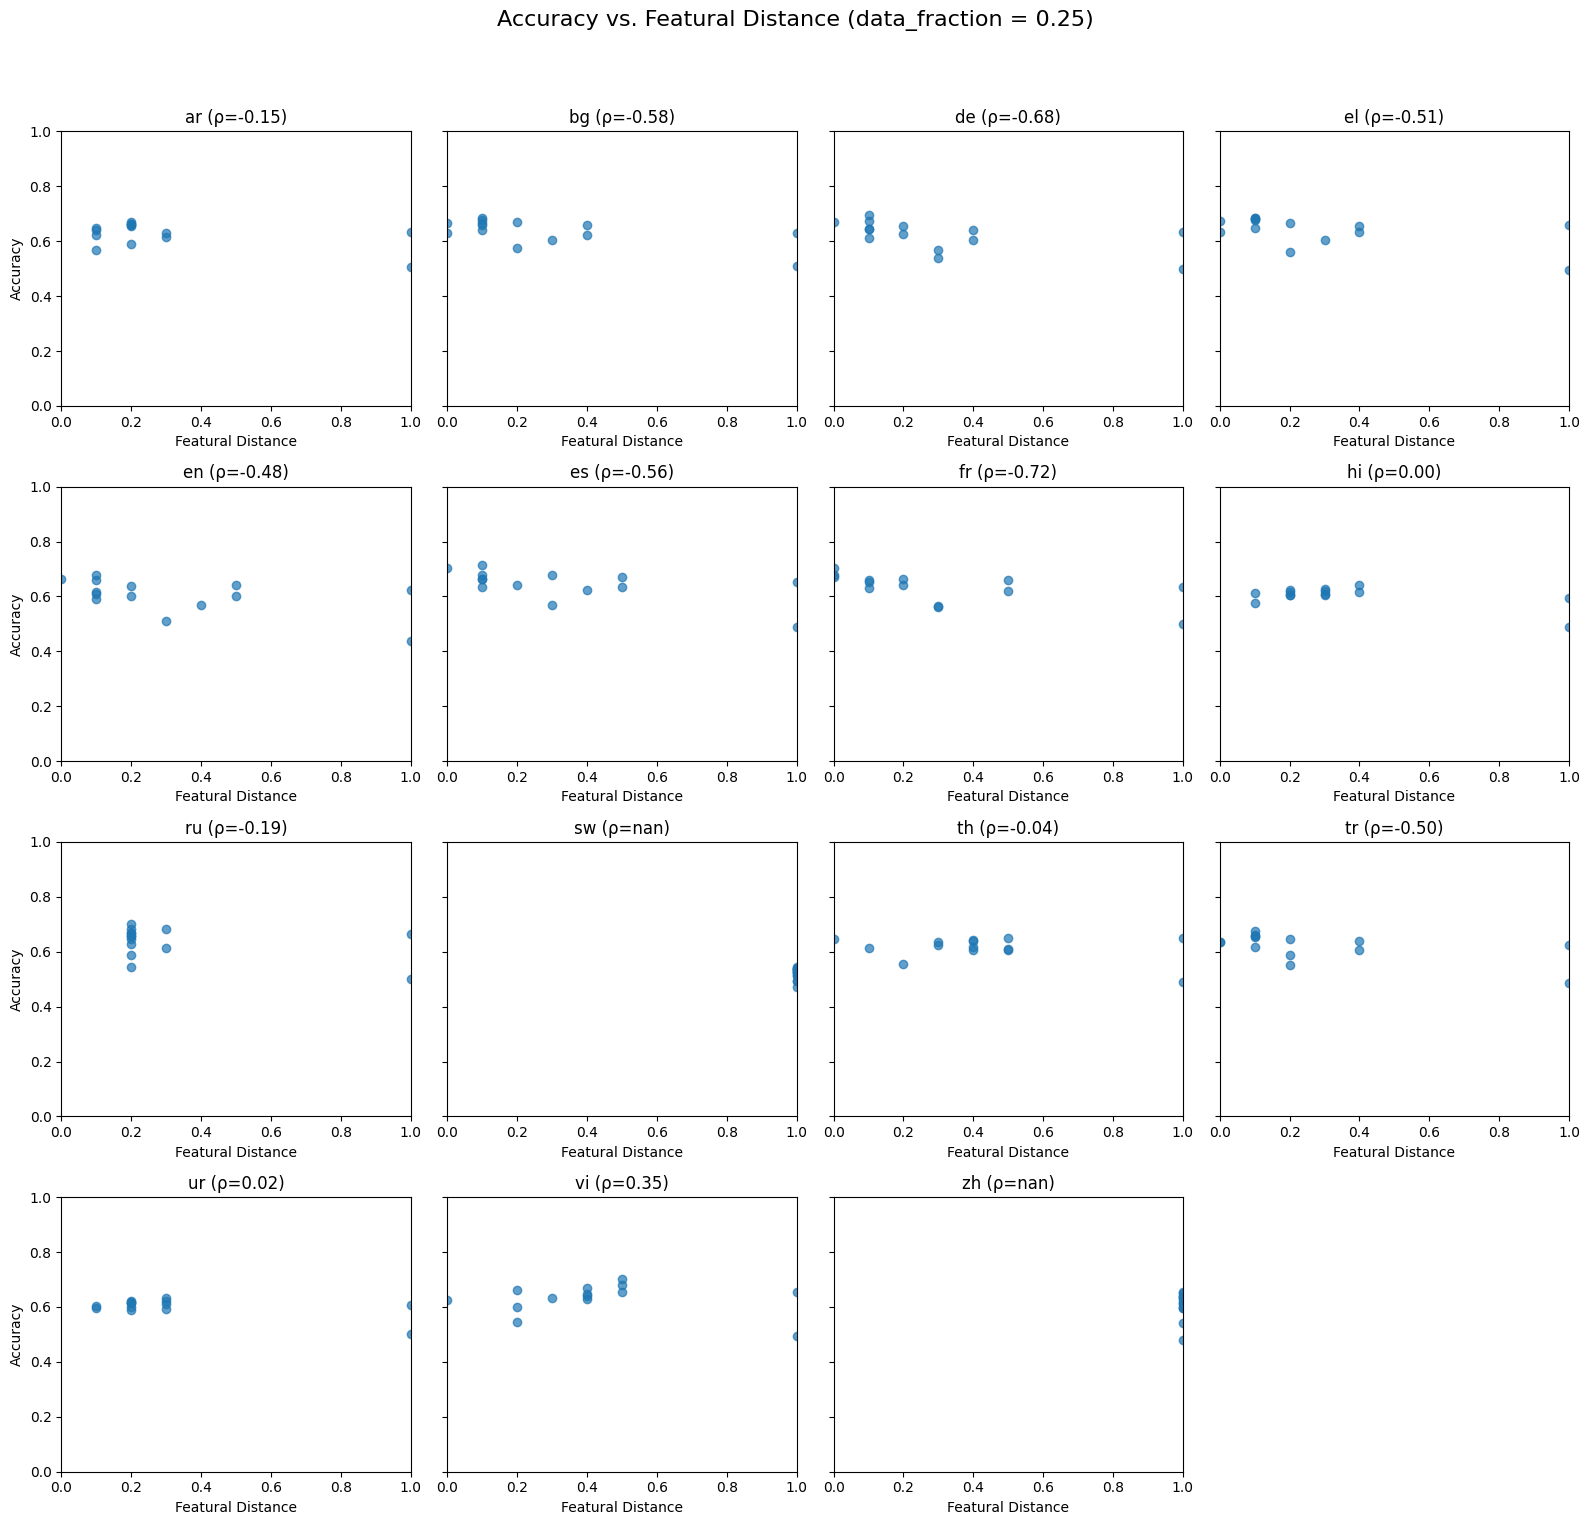

In [13]:
plot_distance_vs_accuracy_per_source(results_per_eval, languages, distance_dfs, DISTANCE, metric='accuracy',data_fraction=0.25)

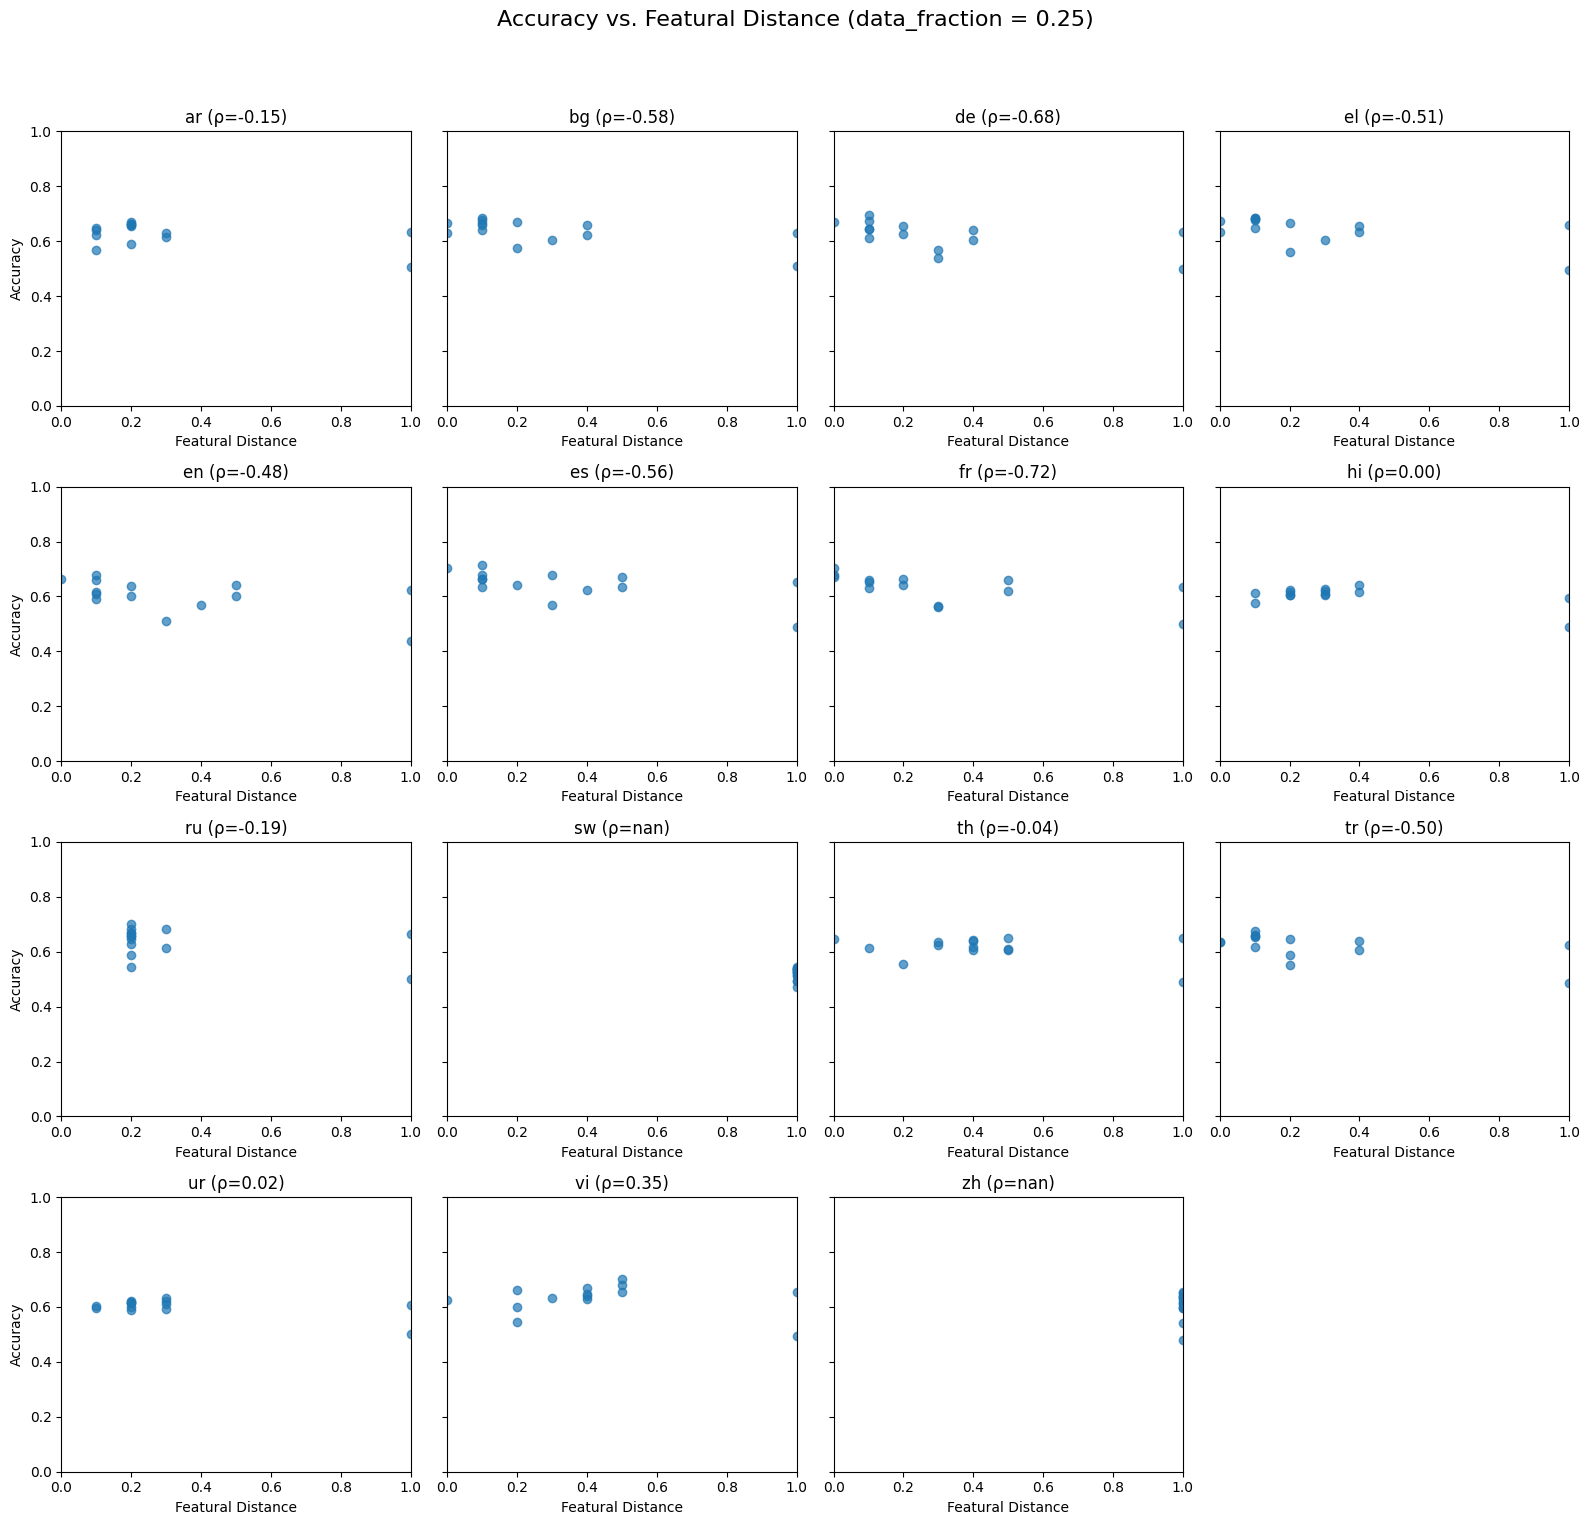

In [17]:
plot_distance_vs_accuracy_per_source(results_per_eval, languages, distance_dfs, DISTANCE ,metric='accuracy',data_fraction=0.25)

## RQ2. Data Availability: Can increasing the amount of data provided during fine-tuning compensate for transferring form more distant language?
- Test whether more fine-tuning data improves cross-lingual transfer, especially from distant languages.
    -  Track accuracy as a function of data fraction used during fine-tuning

### Accuracy vs. Data Fraction (Per Source)

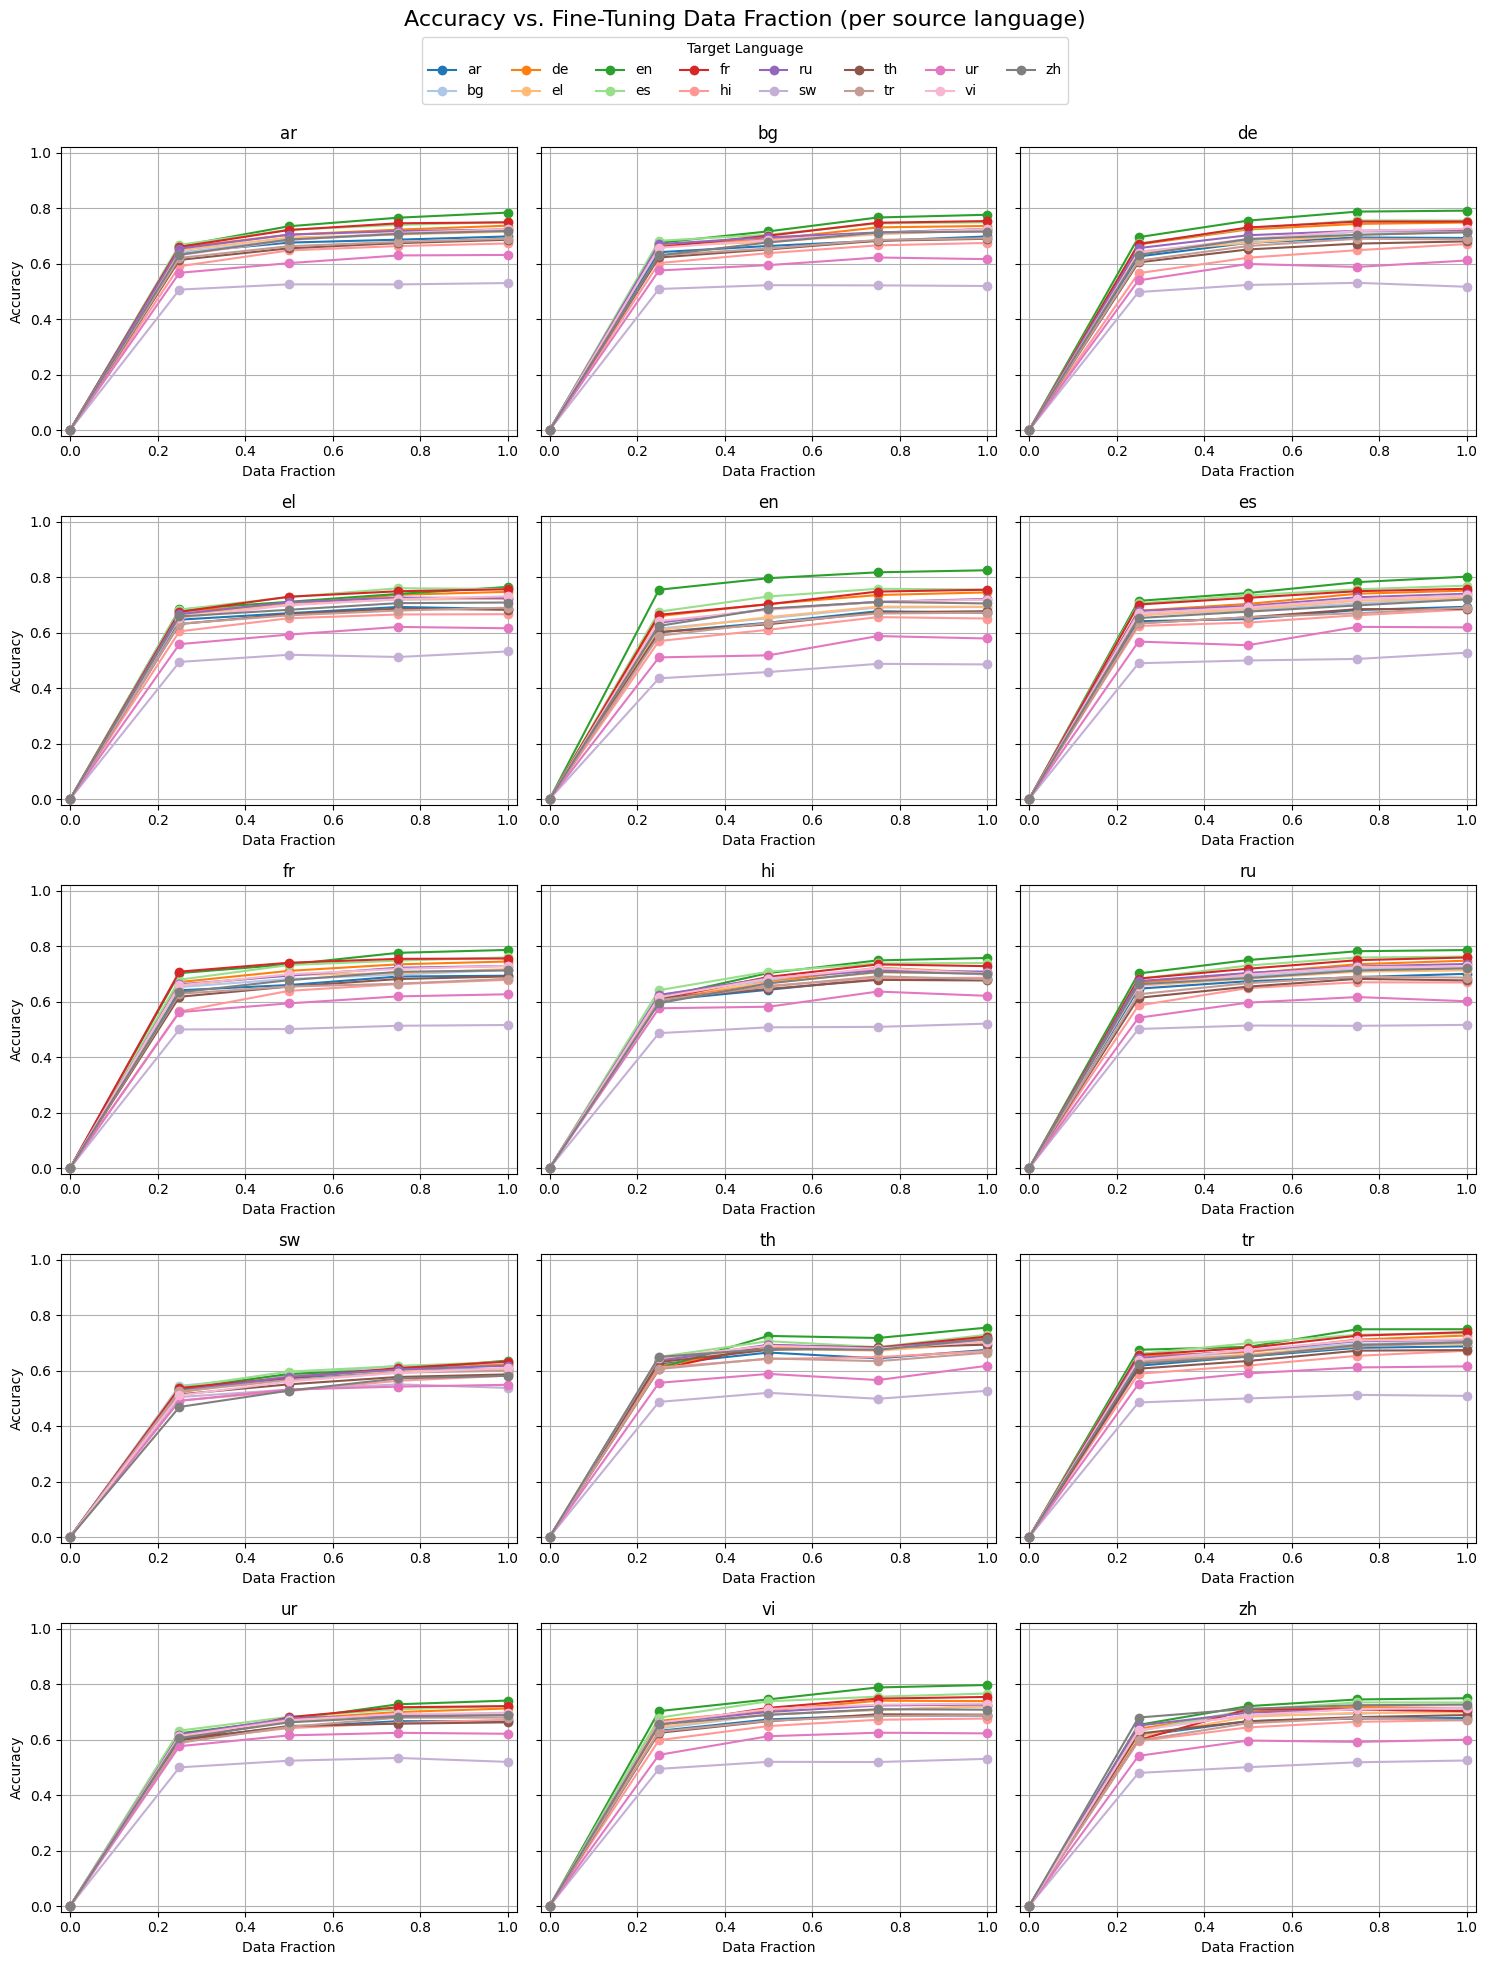

In [18]:
data_fractions = list(results_per_eval[next(iter(results_per_eval))][next(iter(results_per_eval[next(iter(results_per_eval))]))].keys())
plot_accuracy_vs_data_fraction_per_source(results_per_train, fractions=data_fractions, metric='accuracy')

## RQ3. English universality: Given the overwhelming prevalence of English in the training data, is it a good candidate for the universal transfer language?

- Evaluate how well English transfers compared to other source languages.
    - For each target language, compare performance when model is fine-tuned on English vs. other sources (at equal data fraction).
    - For each target language, compute the rank of English among all sources.
    - Check variance in English’s performance as source


### Distribution of accuracy per source language

/home/nico/Documents/repositories/projects/eth/CSNLP/CS4NLP-Cross-Lingual-Task-Adaptation/notebooks/analysis.py:301: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='Source', y='Accuracy', inner='box', palette='muted')


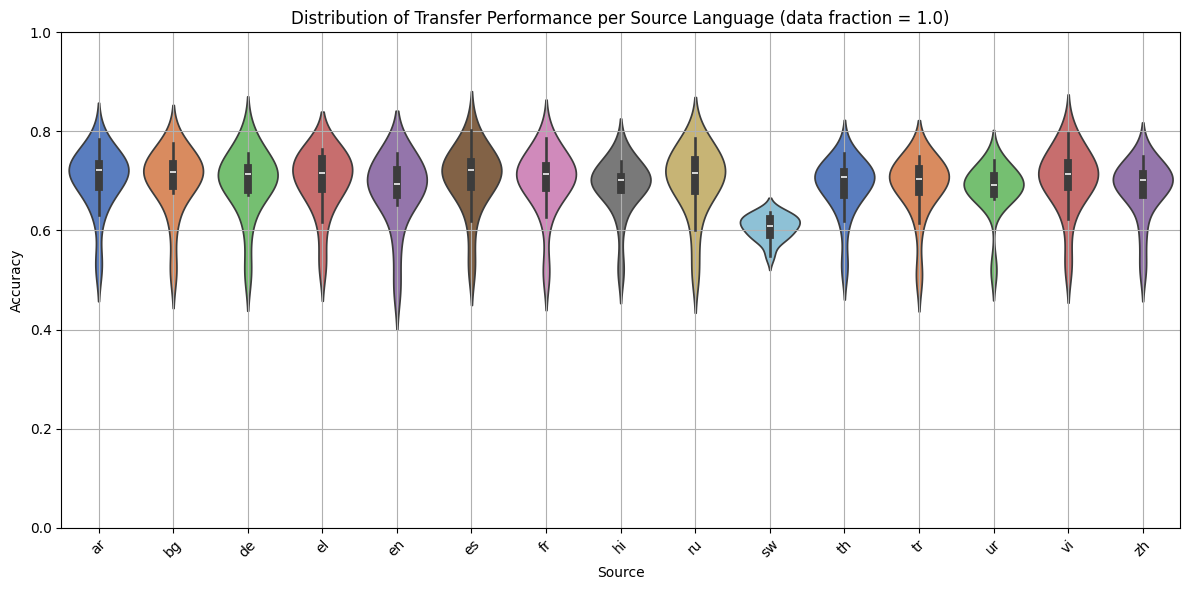

In [19]:
plot_violin_source_transfer_performance(results_per_train, data_fraction=1.0, metric='accuracy')

/home/nico/Documents/repositories/projects/eth/CSNLP/CS4NLP-Cross-Lingual-Task-Adaptation/notebooks/analysis.py:301: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='Source', y='Accuracy', inner='box', palette='muted')


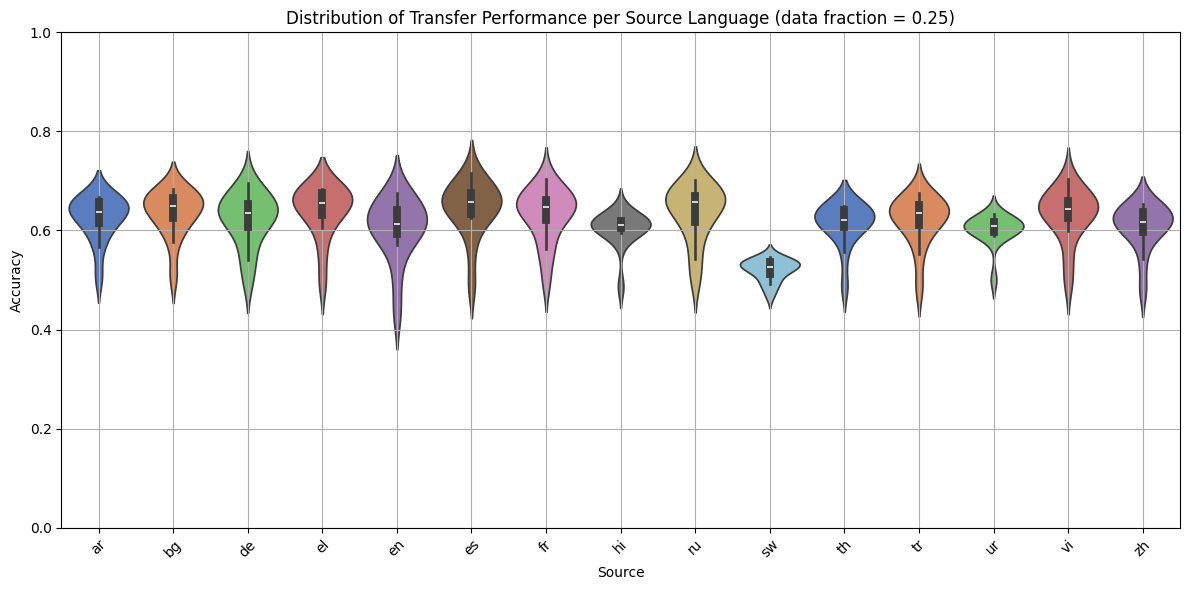

In [20]:
plot_violin_source_transfer_performance(results_per_train, data_fraction=0.25, metric='accuracy')

In [24]:
language_ranks = defaultdict(pd.DataFrame)
language_dist_ranks = defaultdict(pd.DataFrame)
for lang in languages:
    language_ranks[lang] = compute_language_rank_across_targets(
        results_per_train, 
        [0.25, 0.5, 0.75, 1.0], 
        metric='accuracy',  
        language_code=lang
    )
    language_dist_ranks[lang] = compute_language_rank_across_targets(
        results_per_train, 
        [f"{DISTANCE.capitalize()} Distance Rank"], 
        metric='distance',  
        distance_dfs=distance_dfs, 
        distance=DISTANCE, 
        language_code=lang
    )

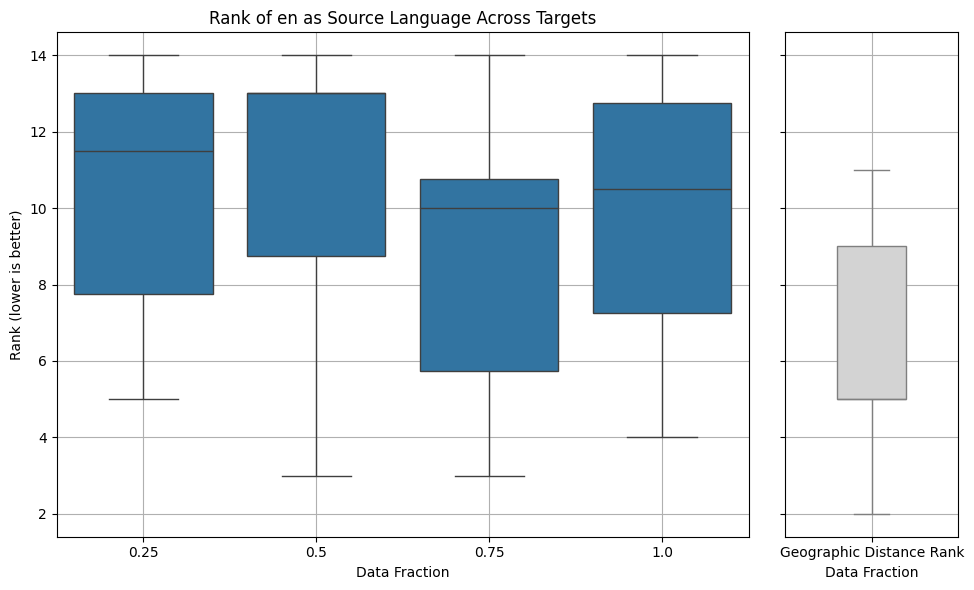

In [27]:
plot_ranks(language_ranks["en"], language_dist_ranks["en"], language_code='en')

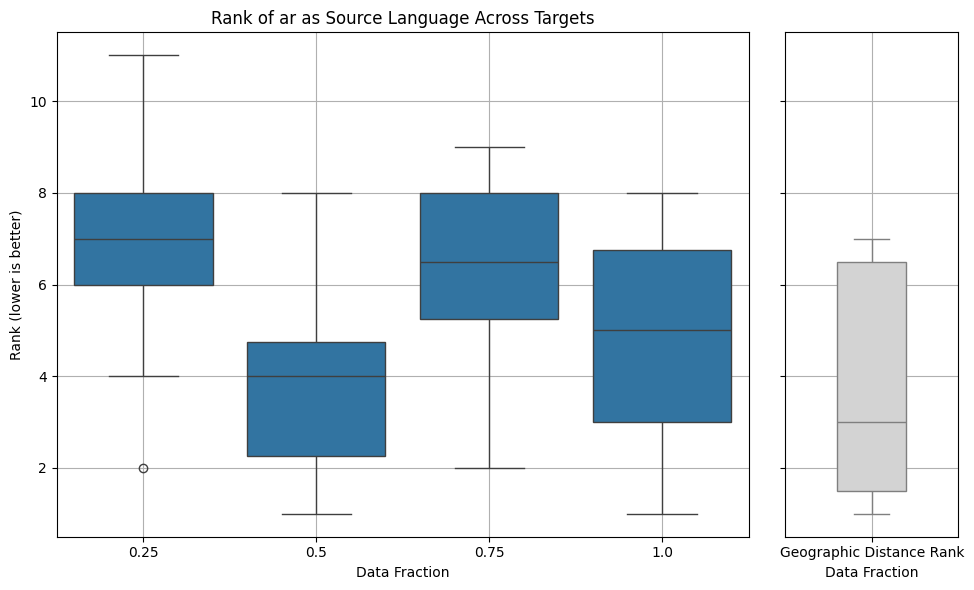

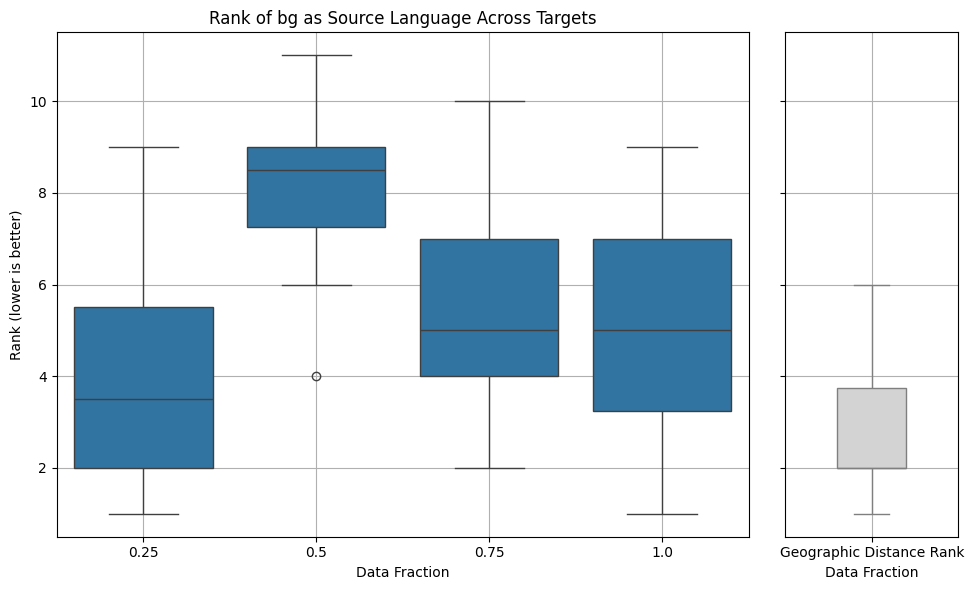

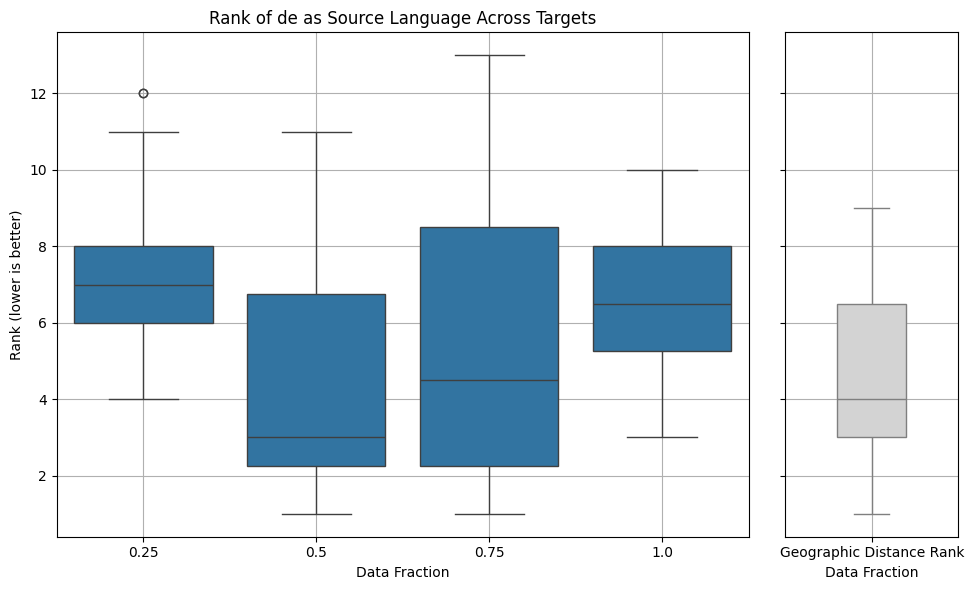

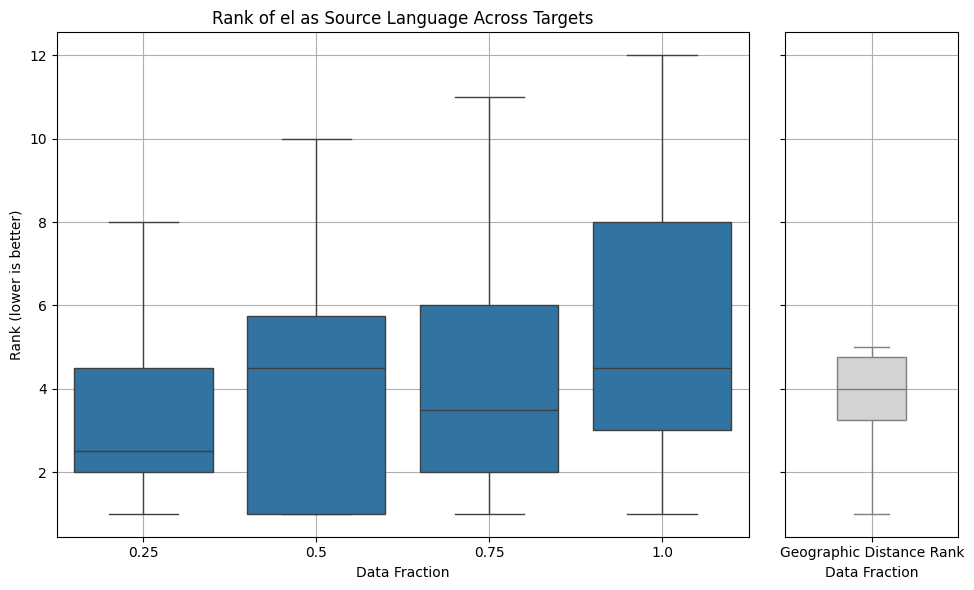

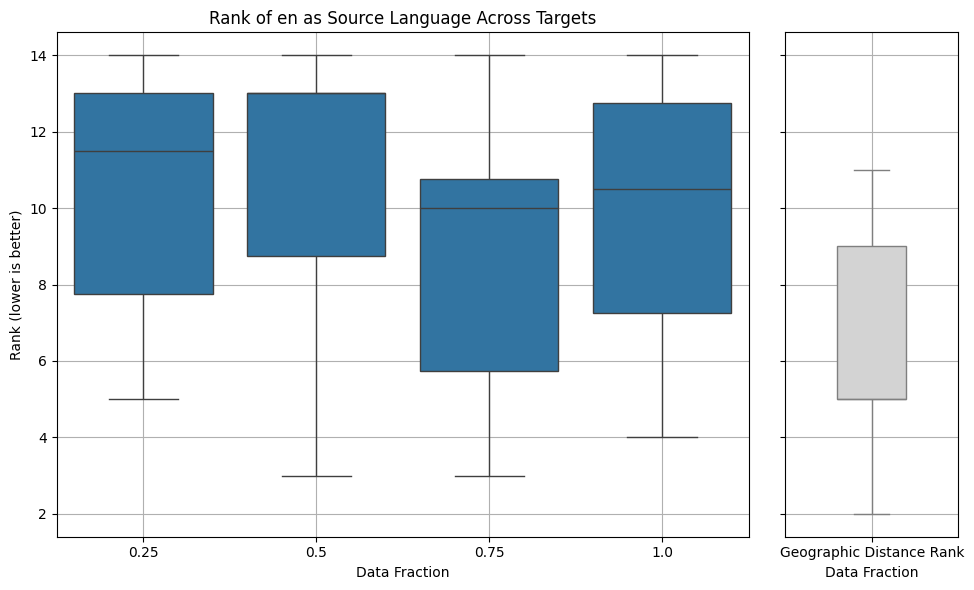

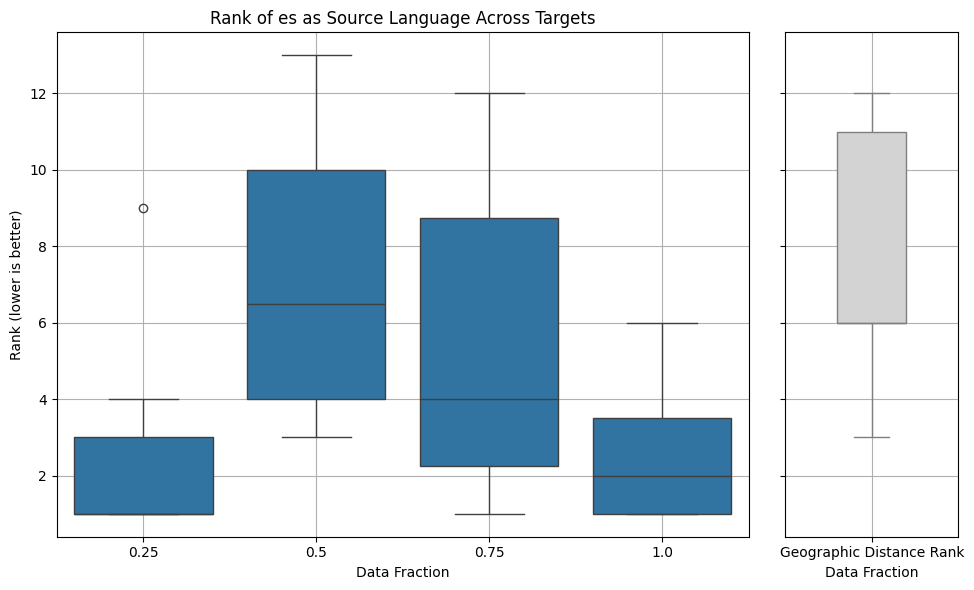

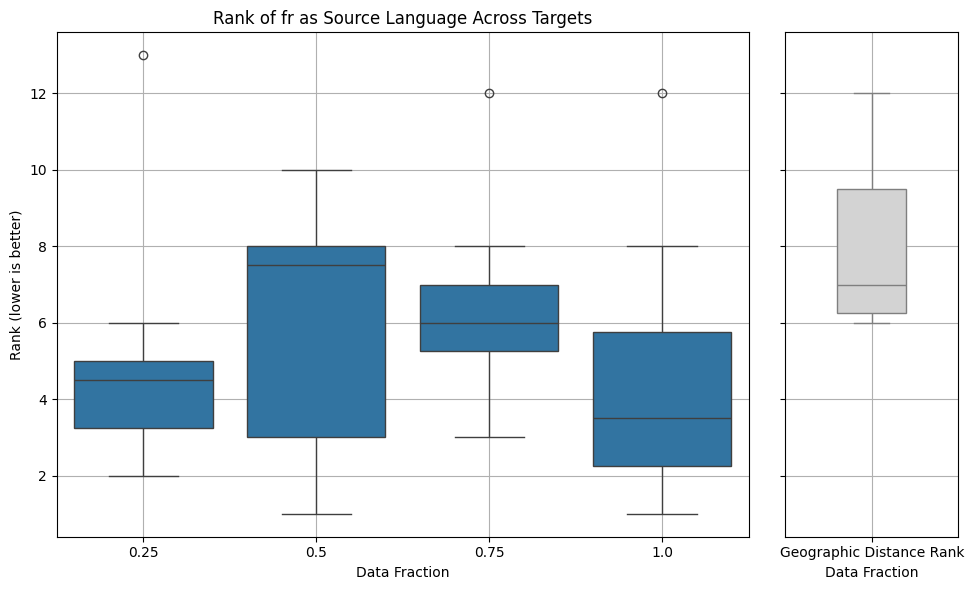

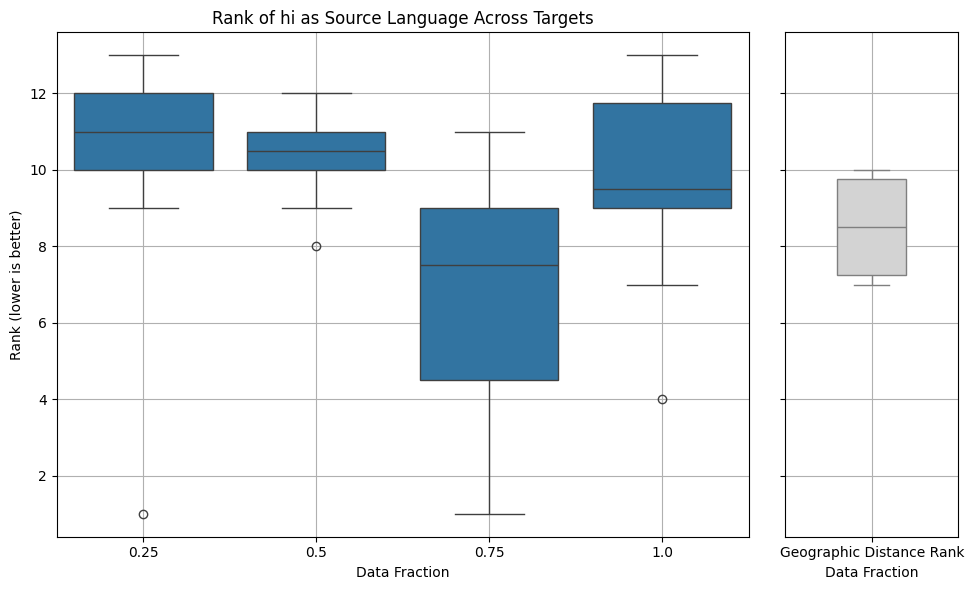

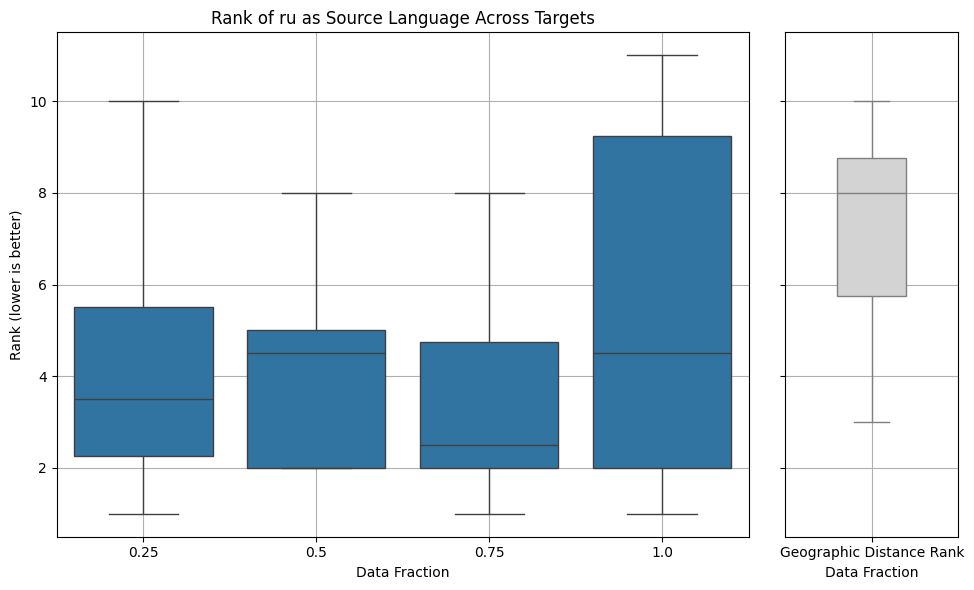

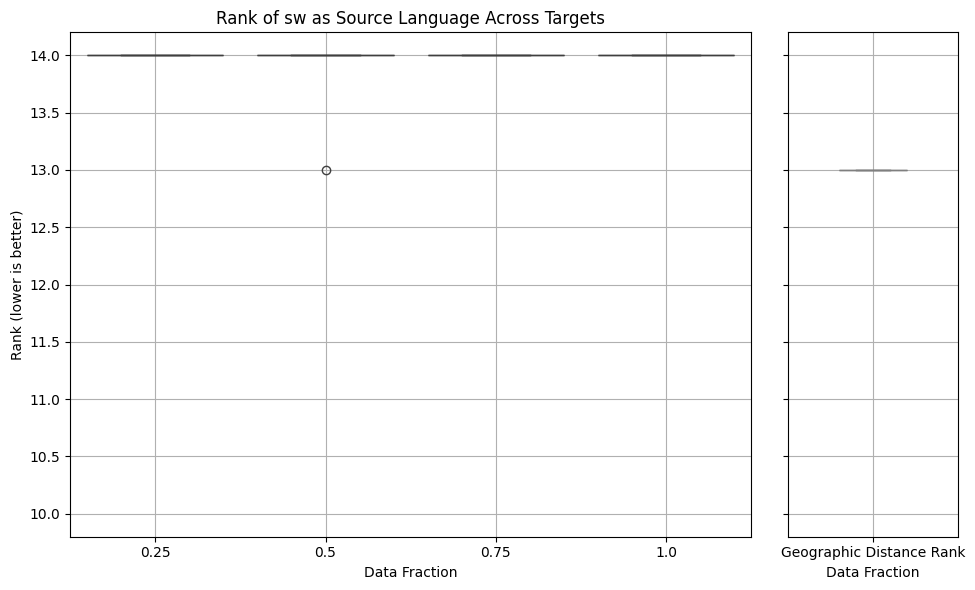

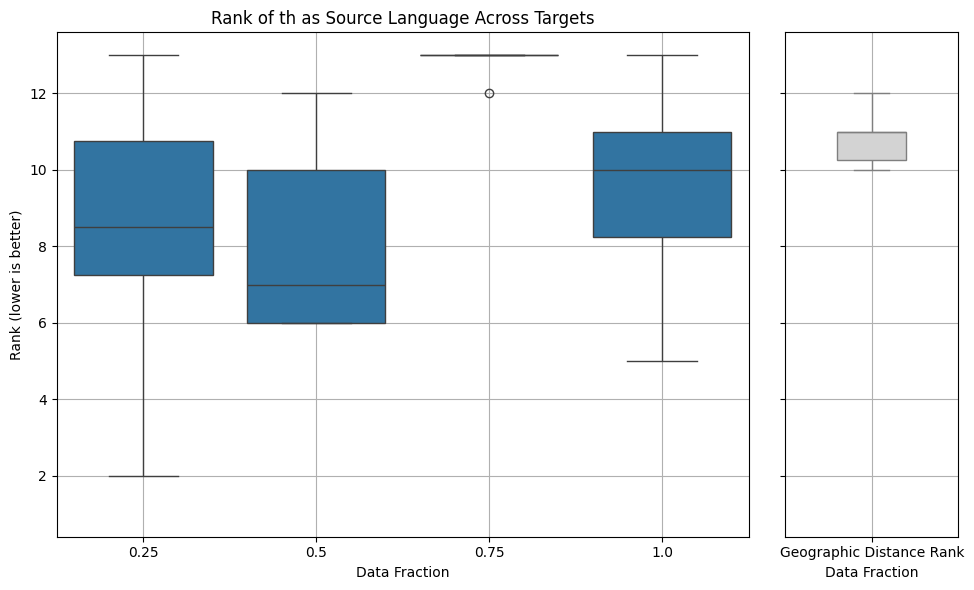

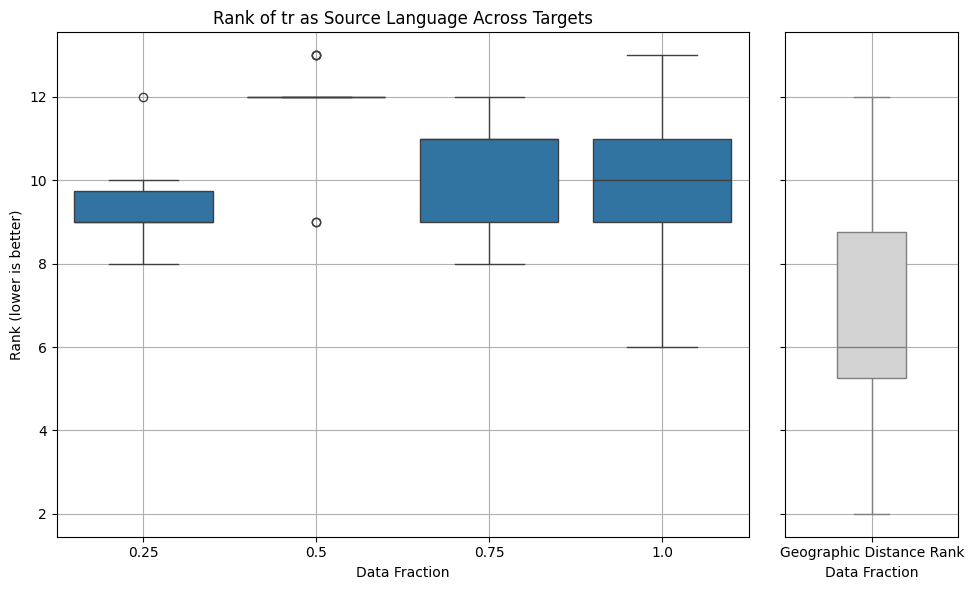

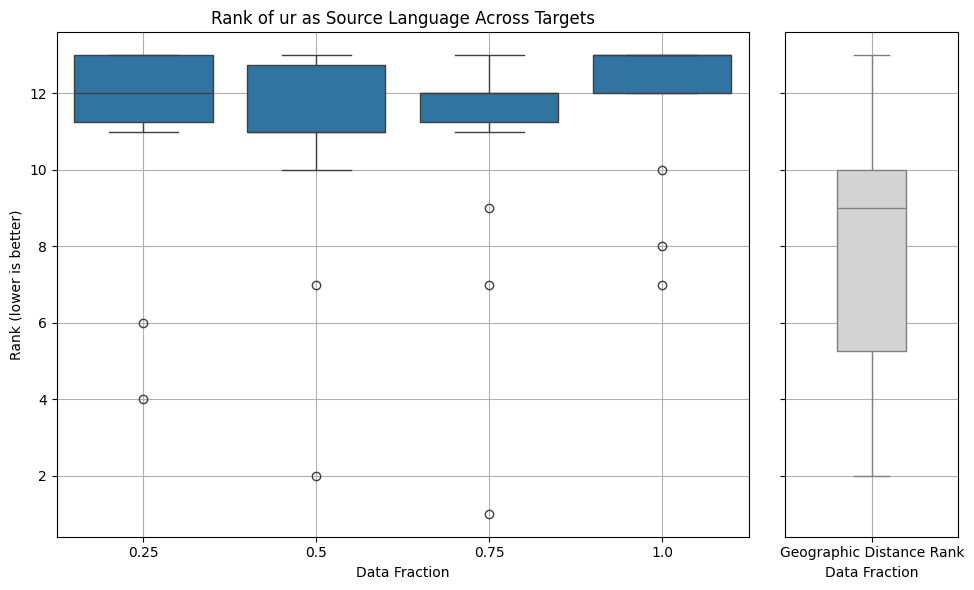

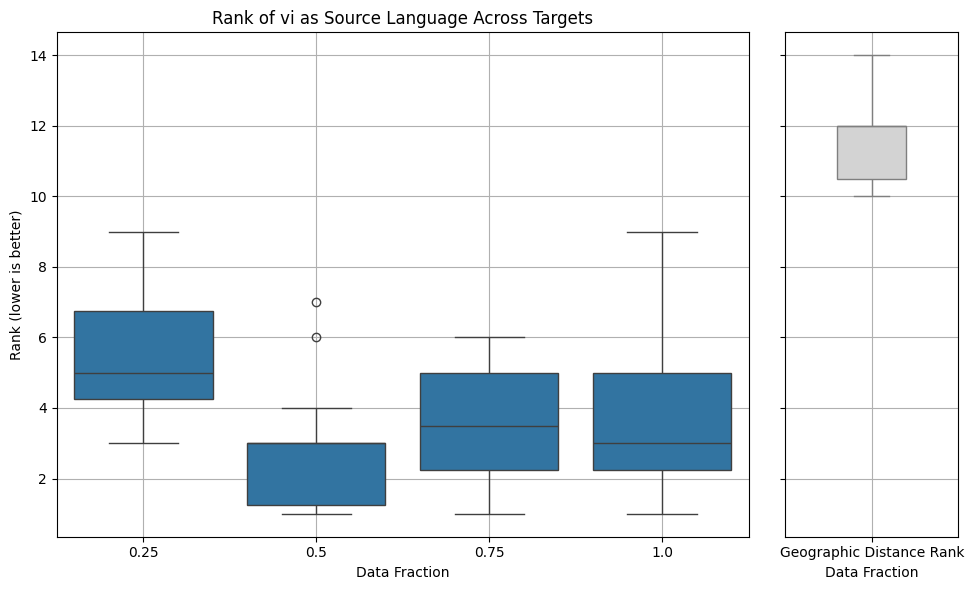

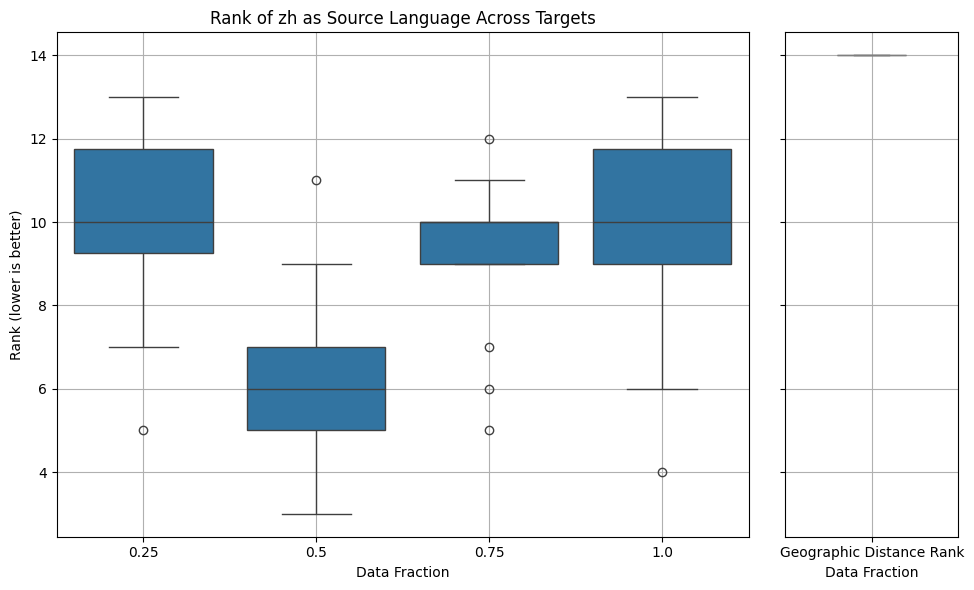

In [28]:
for lang, df in language_ranks.items():
    plot_ranks(ranks_df=df, dist_ranks_df= language_dist_ranks[lang],language_code=lang)

15 source languages found


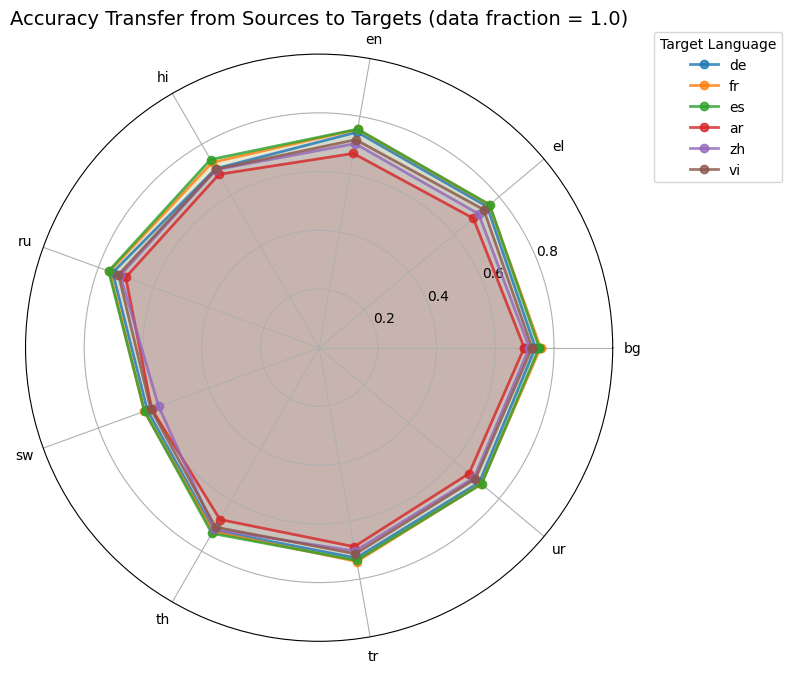

In [29]:
plot_radar_sources_for_targets(
    results_per_train,
    target_langs=['de', 'fr', 'es', 'ar', 'zh', 'vi'],  # your selected targets
    data_fraction=1.0
)

15 source languages found


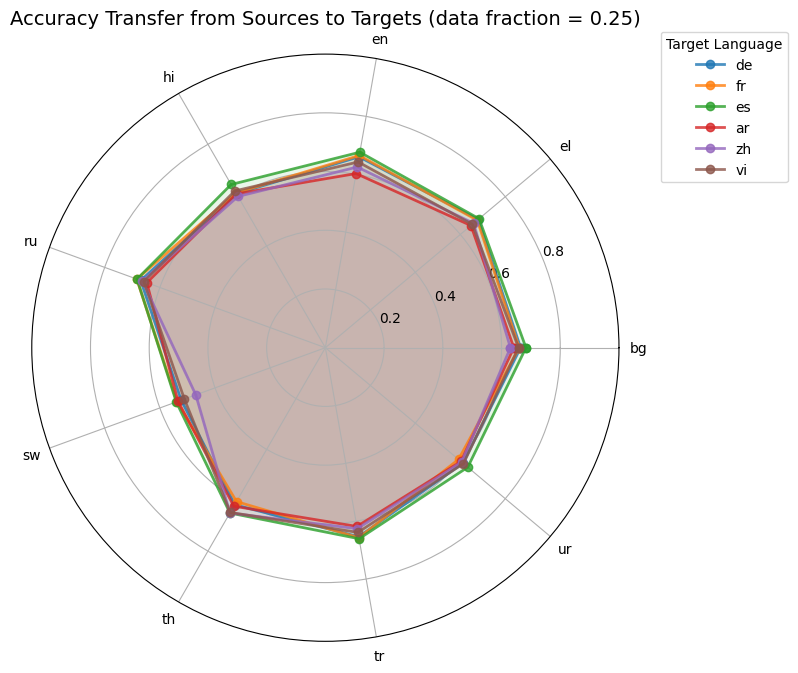

In [30]:
plot_radar_sources_for_targets(
    results_per_train,
    target_langs=['de', 'fr', 'es', 'ar', 'zh', 'vi'],  # your selected targets
    data_fraction=0.25
)